# Imports

In [1]:
import inspect
import logging
import sys

import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np

import torch
import torch.nn
import torch.optim
import torch.utils.data

from IPython.display import clear_output, display, HTML

# Parameters

In [2]:
n_points = 100
n_samples = 1000

# Helper Functions

In [3]:
def plot_sine_waves(values, ax=None):
    ax_is_none = ax is None
    if ax_is_none:
        fig, ax = plt.subplots(figsize=(6, 6))
    
    xx = np.linspace(0, 2*np.pi, values.shape[1])
    ax.plot(xx, values.T)

    ax.set_xticks(np.arange(0, 2.5 * np.pi, np.pi / 2))
    ax.set_xticklabels((r"$0$", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$"))
    
    ax.set_xlim(0, 2*np.pi)
    # ax.set_ylim(-5, 5)
    
    ax.spines["left"].set_position("zero")
    ax.spines["bottom"].set_position("zero")
    
    ax.spines["top"].set_color("none")
    ax.spines["right"].set_color("none")
    
    ax.grid(True, linestyle="--", alpha=0.5)

    if ax_is_none:
        plt.show()

# Dataset

## `NumpyToTensorDataset`

In [4]:
class NumpyToTensorDataset(torch.utils.data.Dataset):
    def __init__(self, dataset: torch.utils.data.Dataset):
        super().__init__()
        args, _, _, values = inspect.getargvalues(inspect.currentframe())
        values.pop("self")
        for arg, val in values.items():
            setattr(self, arg, val)

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        data = self.dataset[idx]
        if isinstance(data, tuple):
            data = tuple(
                torch.tensor(item, dtype=torch.float32) if isinstance(item, np.ndarray) else item
                for item in data
            )
        else:
            data = torch.tensor(data, dtype=torch.float32)
        return data

## `SineDataset`

In [5]:
class SineDataset(torch.utils.data.Dataset):
    def __init__(self, n_points=100, length=10, training=True):
        super().__init__()
        args, _, _, values = inspect.getargvalues(inspect.currentframe())
        values.pop("self")
        for arg, val in values.items():
            setattr(self, arg, val)
        self._xx = np.linspace(0, 2*np.pi, self.n_points)

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        if isinstance(idx, int):
            if idx < 0:
                idx += len(self)
            if idx < 0 or idx >= len(self):
                raise IndexError("Index out of range")
            return self.generate_sample()
        elif isinstance(idx, slice):
            return self.generate_samples(self._slice_length(idx))
        elif isinstance(idx, list) or isinstance(idx, torch.Tensor):
            return self.generate_samples(len(idx))
        else:
            raise TypeError("Index should be an integer, slice, list, or tensor.")

    def _slice_length(self, slice_obj):
        start, stop, step = slice_obj.indices(len(self))
        if step > 0:
            return max(0, (stop - start + (step - 1)) // step)
        elif step < 0:
            return max(0, (start - stop - (step + 1)) // -step)
        else:
            raise ValueError("slice step cannot be zero")
    
    def get_parameters(self, size):
        if self.training:
            A = 0*np.random.uniform(low=1.0, high=2.0, size=size) + 1
            B = 0*np.random.uniform(low=0.75, high=2.0, size=size) + 1
            C = np.random.uniform(low=-5.0, high=5.0, size=size)
            D = 0*np.random.uniform(low=-5.0, high=5.0, size=size)
        else: #low=0.0, high=1.0
            A = 0*np.random.uniform(low=-1.0, high=3.0, size=size) + 1
            B = 0*np.random.uniform(low=0.5, high=5.0, size=size) + 1
            C = np.random.uniform(low=-10.0, high=10.0, size=size)
            D = 0*np.random.uniform(low=-10.0, high=10.0, size=size)
        return A, B, C, D
            
    def generate_sample(self):
        A, B, C, D = self.get_parameters(size=None)
        return np.asarray( (A,B,C,D) ), A*np.sin(B*self._xx+C)+D

    def generate_samples(self, count):
        A, B, C, D = self.get_parameters(size=(count,1))
        return np.column_stack( (A,B,C,D) ), A*np.sin(B*self._xx+C)+D

## Data Visualization

### Targets

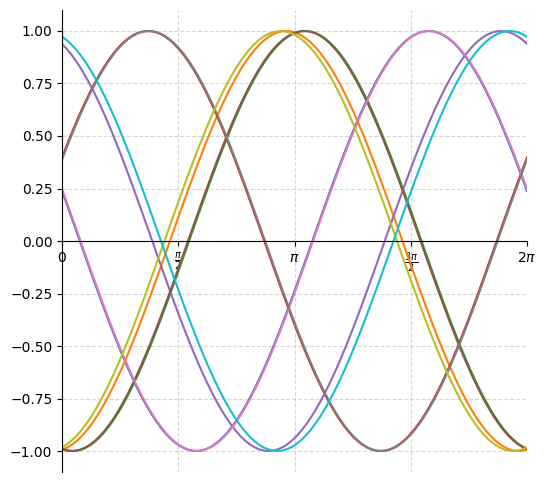

In [6]:
params, samples = SineDataset(n_points=n_points, length=10, training=True)[:]
plot_sine_waves(samples)

### Parameter Distribution

$A\cdot\sin(Bx+C)+D$

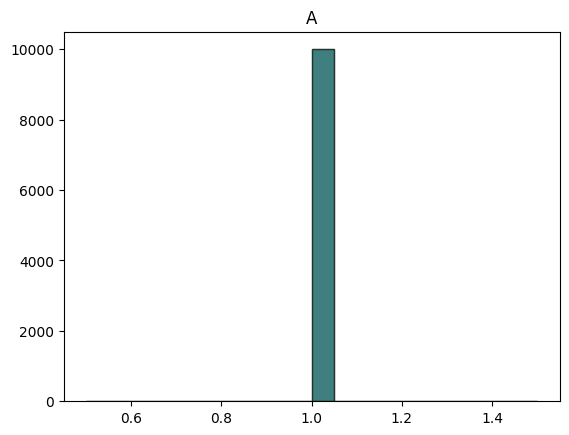

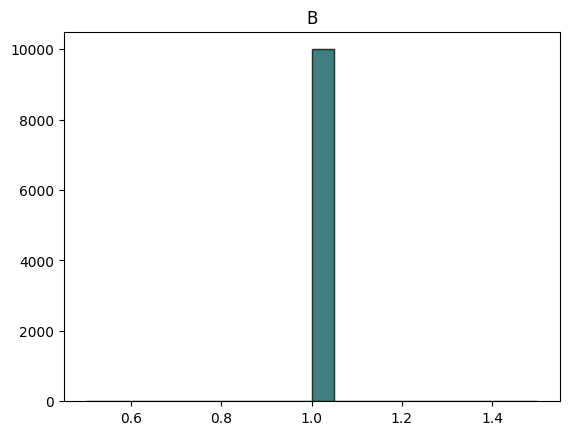

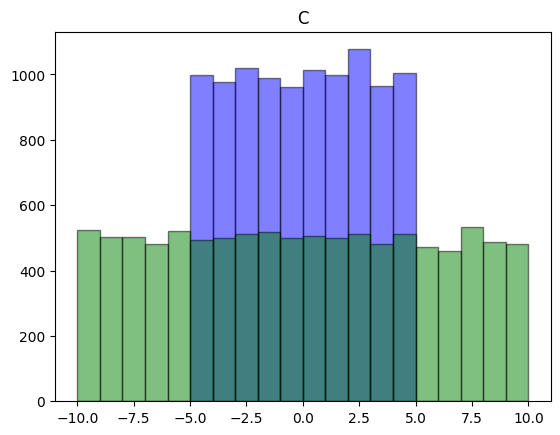

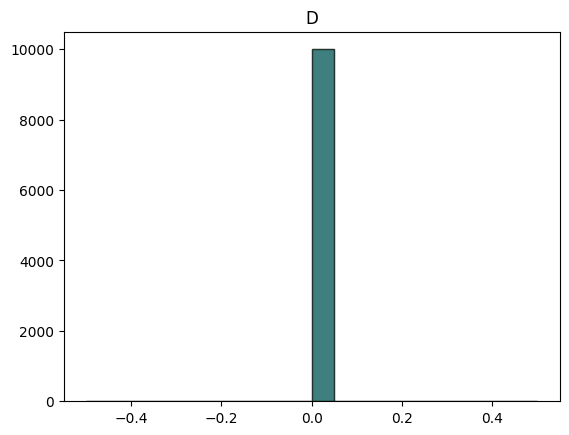

In [7]:
training_x = SineDataset(training=True).get_parameters(10000)
testing_x = SineDataset(training=False).get_parameters(10000)
for ii,label in enumerate( ("A", "B", "C", "D") ):
    bin_edges = np.histogram_bin_edges(
        np.concatenate( (training_x[ii], testing_x[ii]) ),
        bins=20
    )
    
    fig, ax = plt.subplots()
    ax.hist(training_x[ii], bins=bin_edges, alpha=0.5, color="blue", edgecolor="black")
    ax.hist(testing_x[ii], bins=bin_edges, alpha=0.5, color="green", edgecolor="black")
    ax.set_title(label)
    plt.show()

# The Model

In [8]:
class SineCalculator(torch.nn.Module):
    def __init__(self, n_points):
        super().__init__()
        args, _, _, values = inspect.getargvalues(inspect.currentframe())
        values.pop("self")
        for arg, val in values.items():
            setattr(self, arg, val)
        self._model = torch.nn.Sequential(
            torch.nn.Linear(in_features=4, out_features=n_points, bias=True),
            torch.nn.Tanh(),
            torch.nn.Linear(in_features=n_points, out_features=n_points, bias=True),
            torch.nn.Tanh(),
            torch.nn.Linear(in_features=n_points, out_features=n_points, bias=True),
            torch.nn.Tanh(),
            torch.nn.Linear(in_features=n_points, out_features=n_points, bias=True),
        )

    def forward(self, X):
        return self._model(X)

# Callback Handlers

## `Callback`

In [9]:
class Callback:
    def on_train_begin(self, *args, **kwargs):
        pass

    def on_train_end(self, *args, **kwargs):
        pass

    def on_epoch_begin(self, *args, **kwargs):
        pass

    def on_epoch_end(self, *args, **kwargs):
        pass

    def on_mini_batch_begin(self, *args, **kwargs):
        pass

    def on_mini_batch_end(self, *args, **kwargs):
        pass

    @staticmethod
    def notify(callbacks, method_name, *args, **kwargs):
        for obj in callbacks:
            method = getattr(obj, method_name)
            method(*args, **kwargs)

## `LogPerformance`

In [10]:
class LogPerformance(Callback):
    def __init__(
        self,
        criterion,
        training_dataloader=None,
        validation_dataloader=None,
        device="cpu",
        warm_start=False
    ):
        super().__init__()
        args, _, _, values = inspect.getargvalues(inspect.currentframe())
        values.pop("self")
        for arg, val in values.items():
            setattr(self, arg, val)
        self.loss = dict()

    def _get_gradient_norm(self, model):
        return np.sum(tuple(
            param.grad.norm().item()**2
            for name, param in model.named_parameters()
            if param.grad is not None
        ))**0.5
    
    def _get_performance(self, model, dataloader):
        n_samples = 0
        loss = torch.tensor(0., dtype=torch.float32).to(self.device)
        model.to(self.device).eval()
        for x_train,y_train in dataloader:
            n_samples += len(x_train)
            x_train, y_train = x_train.to(self.device), y_train.to(self.device)
            y_pred = model(x_train)
            loss += self.criterion(y_pred, y_train) * len(x_train) if self.criterion.reduction=="mean" else 1
        if self.criterion.reduction == "mean":
            loss /= n_samples
        return loss
    
    def _log_training_performance(self, model, loss_log):
        if self.training_dataloader is None:
            return
        loss = self._get_performance(model, self.training_dataloader)
        training_loss = loss_log.setdefault("training_loss", list())
        training_loss.append(loss.item())
        loss.backward()
        gradient_norm = loss_log.setdefault("gradient_norm", list())
        gradient_norm.append( self._get_gradient_norm(model) )

    def _log_validation_performance(self, model, loss_log):
        if self.validation_dataloader is None:
            return
        with torch.no_grad():
            loss = self._get_performance(model, self.validation_dataloader)
        validation_loss = loss_log.setdefault("validation_loss", list())
        validation_loss.append(loss.item())

    def _log_performance(self, model, loss_log):
        self._log_training_performance(model, loss_log)
        self._log_validation_performance(model, loss_log)

    def on_train_begin(self, n_epochs, model, logs, *args, **kwargs):
        if not self.warm_start:
            self.loss = dict()
        self._log_performance(model, self.loss)
        for key,value in self.loss.items():
            logs[key] = np.asarray(value)

    def on_epoch_begin(self, *args, **kwargs):
        mini_batch_loss = self.loss.setdefault("mini_batch_loss", list())
        mini_batch_loss.append(list())

    def on_epoch_end(self, model, logs, *args, **kwargs):
        self._log_performance(model, self.loss)
        for key,value in self.loss.items():
            logs[key] = np.asarray(value)

    def on_mini_batch_end(self, loss, logs, *args, **kwargs):
        mini_batch_loss = self.loss.setdefault("mini_batch_loss", list())
        mini_batch_loss[-1].append(loss)
        logs["mini_batch_loss"] = np.asarray(mini_batch_loss[-1])

## `PrintProgress`

In [11]:
# 1 final score
# 2 every 10th score
# 3 every 10th score + mini batch summary
# 4 every 10th score + mini batch mini details
# 5 every 10th score + mini batch all details
# 6 every score
# 7 every score + mini batch summary
# 8 every score + mini batch mini details
# 9 every score + mini batch all details

class PrintProgress(Callback):
    def __init__(self, verbose=0, verbose_epoch_mod=10, verbose_mini_batch_mod=10):
        super().__init__()
        args, _, _, values = inspect.getargvalues(inspect.currentframe())
        values.pop("self")
        for arg, val in values.items():
            setattr(self, arg, val)
        self.logger = logging.getLogger("PrintProgress")
        if not self.logger.hasHandlers():
            self.logger.addHandler( logging.StreamHandler(sys.stdout) )
        self.logger.setLevel(logging.DEBUG-verbose)

    def _log_epoch_progress_helper(self, epoch, n_epochs, logs, message_level):
        n_epochs_digits = int(np.log10(n_epochs)) + 1
        # training performance
        training_loss = logs.get("training_loss", [np.nan])[-1]
        # validation performance
        validation_loss = logs.get("validation_loss", [np.nan])[-1]
        # message
        message = (
            f"Epoch: {epoch:>{n_epochs_digits}d}/{n_epochs} ({epoch/n_epochs*100:6.2f}%)   "
            f"Training Loss: {training_loss:.6f}   Validation Loss: {validation_loss:.6f}"
        )
        self.logger.log(level=logging.DEBUG-message_level, msg=message)

    def _log_epoch_progress(self, epoch, n_epochs, logs):
        if epoch == n_epochs:
            message_level = 1
        elif epoch == 0 or epoch % self.verbose_epoch_mod == 0:
            message_level = 2
        else:
            message_level = 6
        self._log_epoch_progress_helper(epoch, n_epochs, logs, message_level)

    def _log_mini_batch_progress_helper(self, epoch, n_epochs, mini_batch, n_batches, batch_size, loss, message_level):
        n_epochs_digits = int(np.log10(n_epochs)) + 1
        n_mini_batch_digits = int(np.log10(n_batches)) + 1
        message = (
            f"Epoch: {epoch:<{n_epochs_digits}d}  "
            f"[{mini_batch:>{n_mini_batch_digits}d}/{n_batches}  ({mini_batch/n_batches*100:3.0f}%)]   "
            f"Loss: {loss:15.6f}"
        )
        self.logger.log(level=logging.DEBUG-message_level, msg=message)

    def _log_mini_batch_summary(self, epoch, n_epochs, logs, message_level):
        mini_batch_loss = logs["mini_batch_loss"]
        mean, std = np.mean(mini_batch_loss), np.std(mini_batch_loss)
        n_epochs_digits = int(np.log10(n_epochs)) + 1
        message = (
            f"Epoch: {epoch:<{n_epochs_digits}d}   "
            f"Mini Batch Average Loss: {mean:.6f} +/- {std:.6f}"
        )
        self.logger.log(level=logging.DEBUG-message_level, msg=message)

    def _log_mini_batch_progress(self, epoch, n_epochs, mini_batch, n_batches, batch_size, loss, logs):
        if epoch == n_epochs or epoch % self.verbose_epoch_mod == 0:
            message_level = 4 if mini_batch % self.verbose_mini_batch_mod == 0 or mini_batch == n_batches else 5
            message_level += 4 if self.verbose >= 6 else 0
        elif mini_batch % self.verbose_mini_batch_mod == 0 or mini_batch == n_batches:
            message_level = 8
        else:
            message_level = 9
        self._log_mini_batch_progress_helper(epoch, n_epochs, mini_batch, n_batches, batch_size, loss, message_level)
        if mini_batch == n_batches:
            if epoch % self.verbose_epoch_mod == 0 or epoch == n_epochs:
                message_level = 3
                message_level += 4 if self.verbose >= 6 else 0
            else:
                message_level = 7
            self._log_mini_batch_summary(epoch, n_epochs, logs, message_level)

    def on_train_begin(self, n_epochs, model, logs, *args, **kwargs):
        self.n_epochs = n_epochs
        self._log_epoch_progress(0, self.n_epochs, logs)

    def on_epoch_end(self, epoch, model, logs, *args, **kwargs):
        self._log_epoch_progress(epoch, self.n_epochs, logs)

    def on_mini_batch_end(self, epoch, mini_batch, n_batches, batch_size, loss, logs, *args, **kwargs):
        self._log_mini_batch_progress(epoch, self.n_epochs, mini_batch, n_batches, batch_size, loss, logs)

## `PlotProgress`

The `PlotProgress` callback handler serves to visualize the loss and accuracy of the network across epochs and mini-batches. Additionally, it generates plots displaying sample digits and their predictions. Note that this handler requires the invocation of the `LogPerformance` handler to ensure accurate data for plotting.

In [12]:
class PlotProgress(Callback):
    def __init__(
        self,
        x_train, y_train,
        x_test, y_test,
        limit_loss,
        device
    ):
        super().__init__()
        args, _, _, values = inspect.getargvalues(inspect.currentframe())
        values.pop("self")
        for arg, val in values.items():
            setattr(self, arg, val)
        assert len(x_train) == len(y_train), "x_train and y_train must have the same length"
        assert len(x_test) == len(y_test), "x_test and y_test must have the same length"

    def _plot_loss(self, ax, training_loss, validation_loss, limit):
        epochs = None
        if training_loss is not None:
            epochs = np.arange(len(training_loss))
            marker = "o" if len(epochs) == 1 else None
            ax.plot(epochs[-limit:], training_loss[-limit:], marker=marker, label="Traning Loss")
        if validation_loss is not None:
            epochs = epochs if epochs is not None else np.arange(len(validation_loss))
            marker = "o" if len(epochs) == 1 else None
            ax.plot(epochs[-limit:], validation_loss[-limit:], marker=marker, label="Validation Loss")
        if epochs is not None:
            ax.set_xlabel("Epoch")
            ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
            ax.set_ylabel("MSE Loss")
            ax.legend()
            
    def _plot_sine_waves(self, fig, gs, y_true, y_pred):
        for ii in range(len(y_true)):
            ax = fig.add_subplot(gs[ii])
            ax.plot(y_true[ii], color="blue")
            ax.plot(y_pred[ii], color="green")

    @torch.no_grad()
    def _plot_results(self, epoch, training_loss, validation_loss, model):
        if epoch % self.limit_loss == 0:
            model.to(self.device).eval()
            
            inputs = torch.from_numpy(self.x_train.astype(np.float32)).to(self.device)
            y_train_pred = model(inputs).to("cpu").numpy()
            
            inputs = torch.from_numpy(self.x_test.astype(np.float32)).to(self.device)
            y_test_pred = model(inputs).to("cpu").numpy()
            
            clear_output(wait=True)
            n_rows = 1 + max(len(self.x_train), len(self.x_test))
            n_cols = 2
            fig = plt.figure(figsize=(n_cols*6.4, n_rows*4.8))
            gs = mpl.gridspec.GridSpec(nrows=n_rows, ncols=n_cols, figure=fig)
            
            self._plot_loss(fig.add_subplot(gs[0,0]), training_loss, validation_loss, -1)
            self._plot_loss(fig.add_subplot(gs[0,1]), training_loss, validation_loss, self.limit_loss)
            
            self._plot_sine_waves(
                fig, gs[1:,0].subgridspec(n_rows-1,1),
                self.y_train,
                y_train_pred
            )
            self._plot_sine_waves(
                fig, gs[1:,1].subgridspec(n_rows-1,1),
                self.y_test,
                y_test_pred
            )
            fig.suptitle(f"Iteration {epoch}", x=(fig.subplotpars.right + fig.subplotpars.left)/2, y=1.001)
            fig.tight_layout()
            plt.show()

    def on_train_begin(self, n_epochs, model, logs, *args, **kwargs):
        self._plot_results(
            0,
            logs.get("training_loss", None),
            logs.get("validation_loss", None),
            model
        )

    def on_epoch_end(self, epoch, model, logs, *args, **kwargs):
        self._plot_results(
            epoch,
            logs.get("training_loss", None),
            logs.get("validation_loss", None),
            model
        )

# Traning

## Training Loop

In [13]:
def time_function(msg="Elapsed Time:"):
    import time
    from datetime import timedelta
    def real_timing_function(function):
        def wrapper(*args, **kwargs):
            start_time = time.time()
            res = function(*args, **kwargs)
            elapsed = time.time() - start_time
            print(msg, timedelta(seconds=elapsed))
            return res
        return wrapper
    return real_timing_function

@time_function("Training Time:")
def train_model(
    model,
    device,
    dataloader,
    criterion,
    optimizer,
    n_epochs,
    callbacks=None,
    logs=None
):
    if callbacks is None:
        callbacks = list()
    if logs is None:
        logs = dict()
    
    # notify each callback of the beginning of training
    Callback.notify(
        callbacks, "on_train_begin",
        n_epochs=n_epochs, model=model, logs=logs
    )
    
    for epoch in range(1,n_epochs+1):
        # notify each callback of the beginning of the epoch
        Callback.notify(
            callbacks, "on_epoch_begin",
            epoch=epoch, n_epochs=n_epochs, model=model, logs=logs
        )
        for mini_batch,(x_train,y_train) in enumerate(dataloader, 1):
            # notify each callback of the mini batch
            Callback.notify(
                callbacks, "on_mini_batch_begin",
                mini_batch=mini_batch, n_batches=len(dataloader), batch_size=len(x_train),
                epoch=epoch, n_epochs=n_epochs, model=model, logs=logs
            )
            
            # zero out the generator gradients
            optimizer.zero_grad()
            model.to(device).train()

            # pass the data through the model and compute the loss
            x_train, y_train = x_train.to(device), y_train.to(device)
            y_pred = model(x_train)
            loss = criterion(y_pred, y_train)

            # compute the gradients and update the model's weights
            loss.backward()
            optimizer.step()
    
            # notify each callback of the mini batch
            Callback.notify(
                callbacks, "on_mini_batch_end",
                mini_batch=mini_batch, n_batches=len(dataloader), batch_size=len(x_train),
                epoch=epoch, n_epochs=n_epochs,
                loss=loss.item(), model=model, logs=logs
            )
        
        # notify each callback of the end of the epoch
        Callback.notify(
            callbacks, "on_epoch_end",
            epoch=epoch, n_epochs=n_epochs, model=model, logs=logs
        )

    # notify each callback of the end of training
    Callback.notify(
        callbacks, "on_train_end",
        model=model, logs=logs
    )

## Training Parameters

In [14]:
n_epochs = 1000
batch_size = 32
shuffle = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mse_loss = torch.nn.MSELoss(reduction="mean")

calculator = SineCalculator(n_points=n_points)
adam_optimizer = torch.optim.Adam(calculator.parameters())

print(device)
print(calculator)

cpu
SineCalculator(
  (_model): Sequential(
    (0): Linear(in_features=4, out_features=100, bias=True)
    (1): Tanh()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): Tanh()
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): Tanh()
    (6): Linear(in_features=100, out_features=100, bias=True)
  )
)


## Data Loaders

In [15]:
training_dataloader = torch.utils.data.DataLoader(
    NumpyToTensorDataset(SineDataset(n_points=n_points, length=n_samples, training=True)),
    batch_size=batch_size,
    shuffle=False,
)

## Initialize Callbacks

In [16]:
log_performance = LogPerformance(
    criterion=mse_loss,
    training_dataloader=torch.utils.data.DataLoader(
        NumpyToTensorDataset(SineDataset(n_points=n_points, length=100, training=True)),
        batch_size=100,
        shuffle=False,
    ),
    validation_dataloader=torch.utils.data.DataLoader(
        NumpyToTensorDataset(SineDataset(n_points=n_points, length=100, training=False)),
        batch_size=100,
        shuffle=False,
    ),
    device=device
)

print_progress = PrintProgress(
    verbose=2,
    verbose_epoch_mod=10
)

x_training, y_training = SineDataset(n_points=n_points, length=5, training=True)[:]
x_testing, y_testing = SineDataset(n_points=n_points, length=5, training=False)[:]
plot_progress = PlotProgress(
    limit_loss=50,
    x_train=x_training[:10], y_train=y_training[:10],
    x_test=x_testing[:10], y_test=y_testing[:10],
    device=device
)

callbacks = (log_performance, print_progress, plot_progress)

## Train the Model

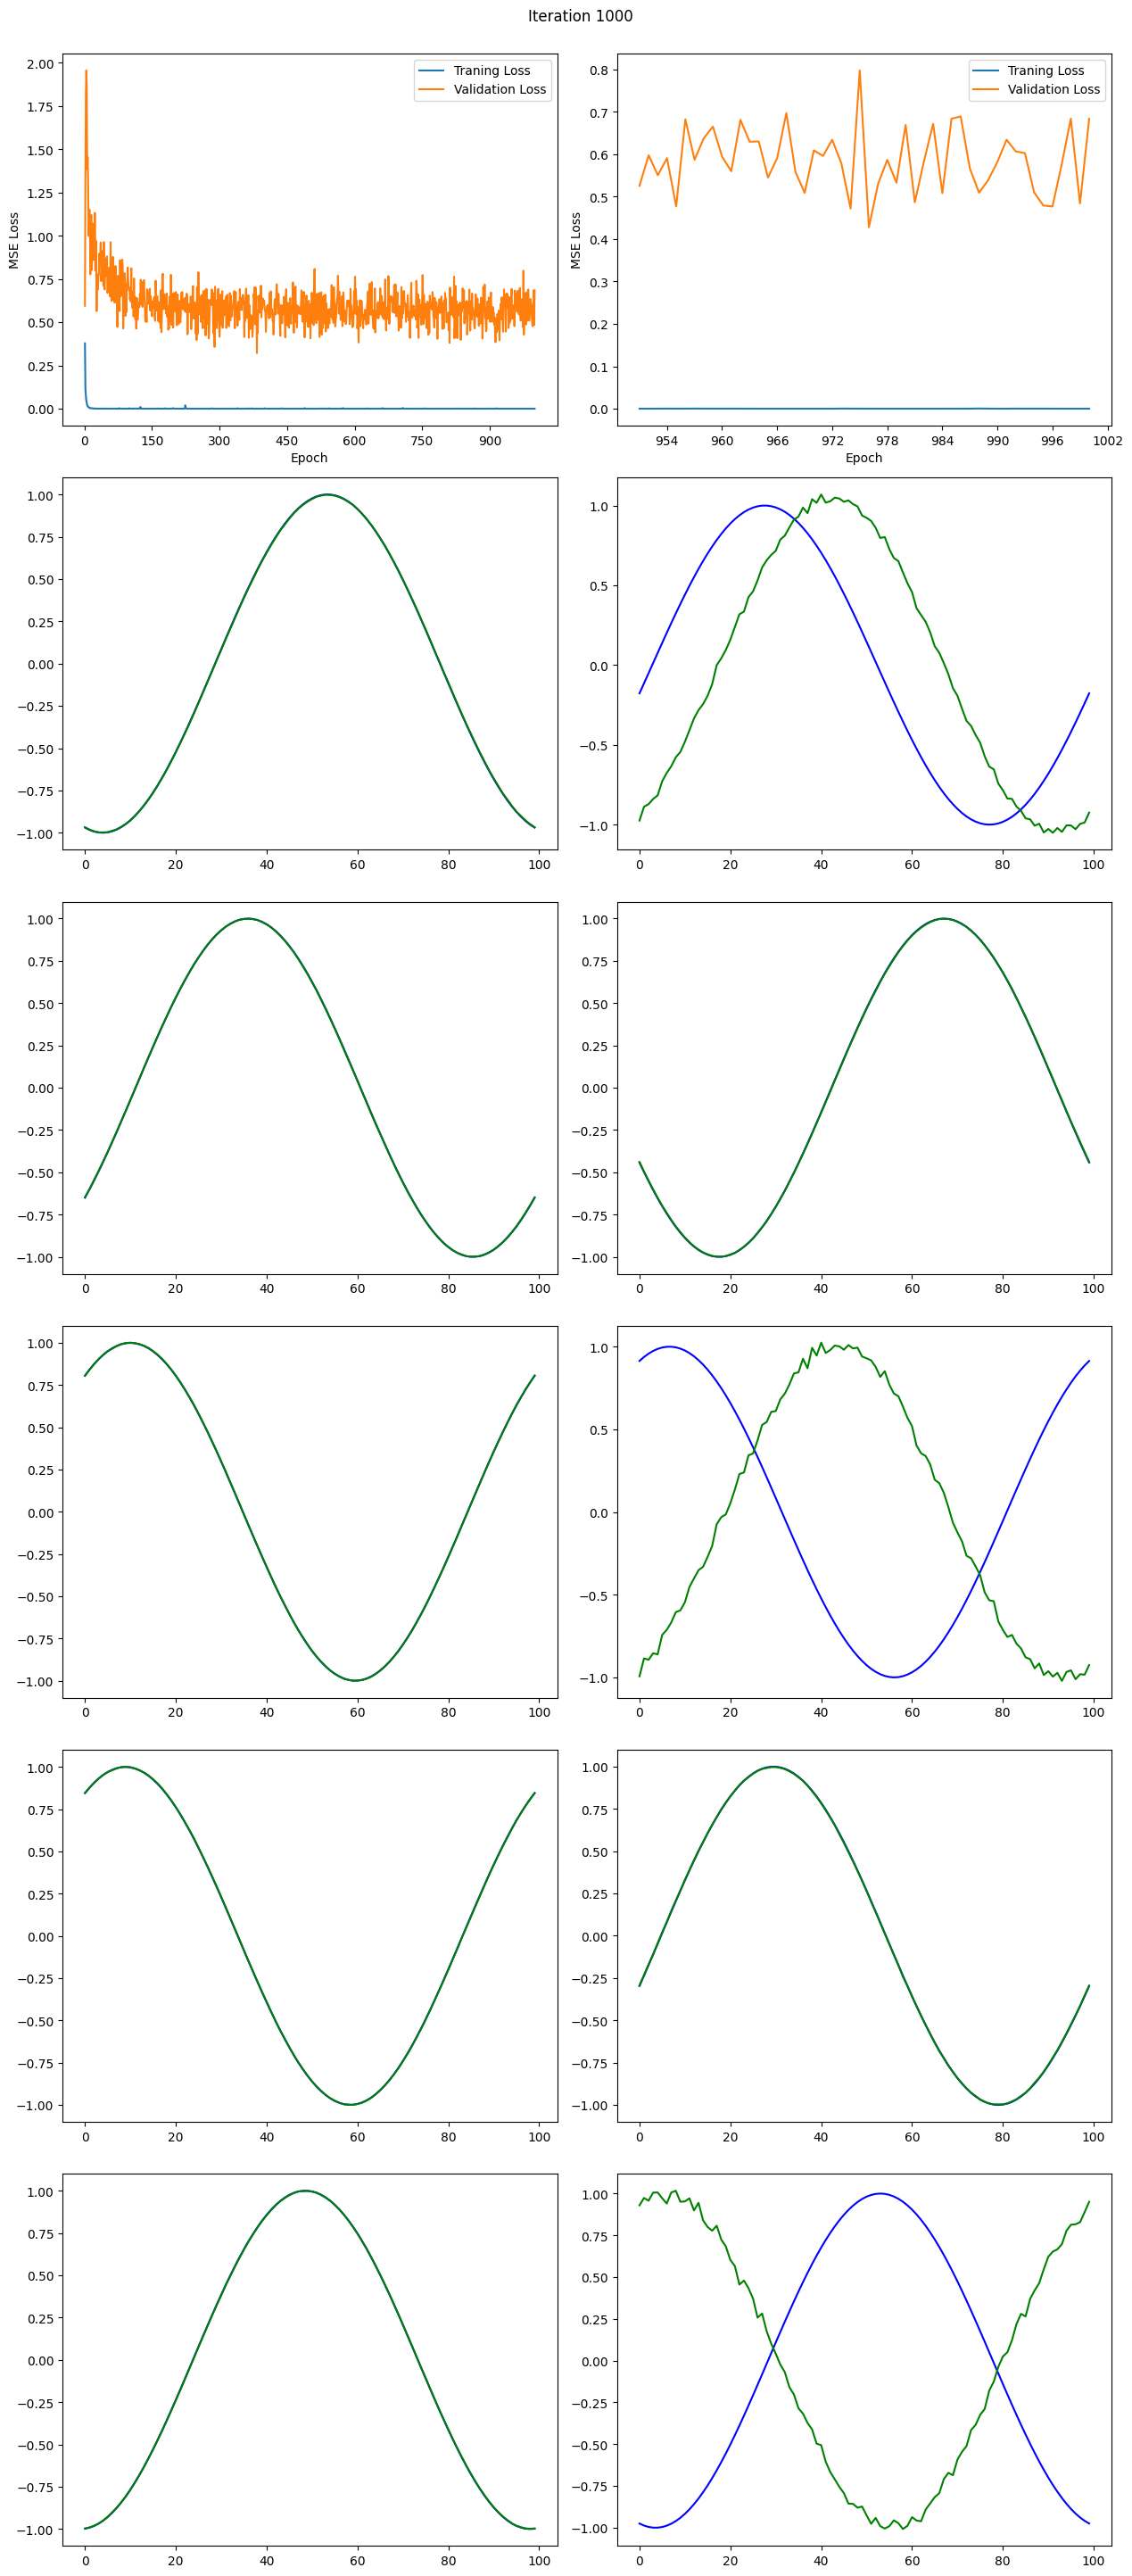

Training Time: 0:02:11.041174


In [17]:
logs = dict()
train_model(
    model=calculator,
    device=device,
    dataloader=training_dataloader,
    criterion=mse_loss,
    optimizer=adam_optimizer,
    n_epochs=n_epochs,
    callbacks=callbacks,
    logs=logs
)

In [18]:
n_test_samples = 100

# A = np.linspace(-1, 3, n_test_samples).reshape(n_test_samples,1)
# B = np.ones(shape=(n_test_samples,1))
# C = np.linspace(-10, 10, n_test_samples).reshape(n_test_samples,1)
# D = np.linspace(-10, 10, n_test_samples).reshape(n_test_samples,1)

A = np.ones(shape=(n_test_samples,1))
B = np.ones(shape=(n_test_samples,1))
C = np.linspace(-20, 20, n_test_samples).reshape(n_test_samples,1)
D = np.zeros(shape=(n_test_samples,1))

xx = np.linspace(0, 2*np.pi, n_points)
y_true = A * np.sin(B*xx + C) + D
with torch.no_grad():
    inputs = np.column_stack( (A,B,C,D) )
    inputs = torch.from_numpy(inputs.astype(np.float32)).to(device)
    y_pred = calculator(inputs).to("cpu").numpy()

# Evaluation

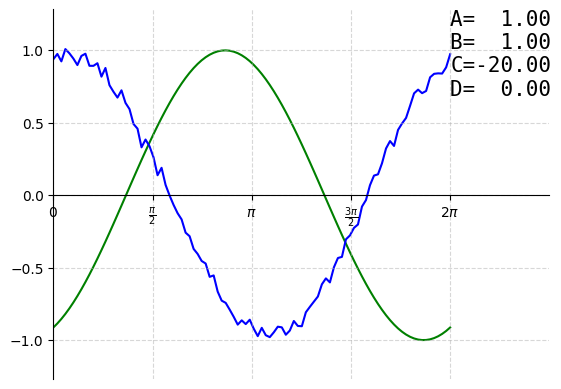

0 0 0 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

In [19]:
y_min, y_max = np.min((y_true.min(), y_pred.min())), np.max((y_true.max(), y_pred.max()))
delta = y_max - y_min
y_min, y_max = y_min - 0.1*delta, y_max + 0.1 * delta

label = (
    f"A={A[0,0]:6.2f}"
    f"\nB={B[0,0]:6.2f}"
    f"\nC={C[0,0]:06.2f}"
    f"\nD={D[0,0]:6.2f}"
)

fig,ax = plt.subplots()

text = ax.text(xx[-1], y_max, label, fontsize=15, family="monospace", ha="left", va="top")
true_line, = ax.plot(xx, y_true[0], color="green", zorder=0)
pred_line, = ax.plot(xx, y_pred[0], color="blue", zorder=1)

ax.set_xticks(np.arange(0, 2.5 * np.pi, np.pi / 2))
ax.set_xticklabels( (r"$0$", r"$\frac{\pi}{2}$", r"$\pi$", r"$\frac{3\pi}{2}$", r"$2\pi$") )

ax.set_xlim(0, 2.5*np.pi)
ax.set_ylim(y_min, y_max)

ax.spines["left"].set_position("zero")
ax.spines["bottom"].set_position("zero")

ax.spines["top"].set_color("none")
ax.spines["right"].set_color("none")

ax.grid(True, linestyle="--", alpha=0.5)

plt.show()

def update(frame_idx):
    print(frame_idx, end=" ")
    label = (
        f"A={A[frame_idx,0]:6.2f}"
        f"\nB={B[frame_idx,0]:6.2f}"
        f"\nC={C[frame_idx,0]:6.2f}"
        f"\nD={D[frame_idx,0]:6.2f}"
    )
    text.set_text(label)
    true_line.set_data(xx, y_true[frame_idx])
    pred_line.set_data(xx, y_pred[frame_idx])
    return true_line,pred_line,text

def init():
    return update(0)

animation = FuncAnimation(
    fig, update, init_func=init,
    frames=n_test_samples, interval=100, blit=True
)

display(
    HTML(animation.to_jshtml(default_mode="loop"))
)